# Machine Learning Predictions (Random Forest) and Feature Importance for the 2019-2020 All-NBA team

**This notebook is an extension of the 2020 Neural Net notebook (https://github.com/aratzan/NBA-Machine-Learning/blob/master/2020-Neural-Net-All-NBA-Team-Predictor.ipynb). It primarily explores how other models fair against neural network predictions and which features are most important for each category.**
## Introduction 
Every NBA season a panel of sportswriters and broadcasters throughout the United States and Canada vote on the All-NBA teams. The All-NBA teams acknowledge the best players in the NBA by position. There are 3 ranked teams (1st, 2nd, 3rd) each consisting of 2 guards, 2 forwards, and 1 center, combining for a total of 15 All-NBA players. Not only is it a huge honor to be selected to an All-NBA team, but it is also important for contract negotiations as players can only be paid certain amounts if they achieve All-NBA accolades for a certain number of years.

With this in mind, wouldn't it be cool for General Managers to predict who will make the All-NBA teams each year based on players stat lines? Such a predictor could provide valuable information on contract negotiations as well as how trades might affect revenue stream. 

This notebook explores exactly that... how well can we leverage Machine Learning to build a highly accurate All-NBA team predictor.

## TLDR: Link for full NBA ML project presentation https://docs.google.com/presentation/d/1GAcQrv--O6522p817_GfwxO8wyjRE0g2agpECrs6I0A/edit?usp=sharing 
Collaborators: Ari Hirsch (Columbia University), Jordan Ramos (Columbia University, github: jordanpramos)

### To note
**You must use pip to install basketball_reference_web_scraper otherwise this notebook won't work. Install it using the following command: pip install basketball_reference_web_scraper** 

Note: I originally had an issue installing it which was solved by running the command like this:
pip install basketball_reference_web_scraper --ignore-installed

**If you would like to run the notebook please run each cell in order!! The first cell takes a while to run since it is retrieving a lot of data. Just wait for it to finish**

## Table of Contents

[Data Acquisition and Structuring](#data_retrieval)
<a href='#data_retrieval'></a>

[Model Training](#model_training)
<a href='#model_training'></a>

[Performance of Random Forest](#results)
<a href='#results'></a>

[Feature Importance](#feature)
<a href='#feature'></a>


## Data Acquisition and Structuring
<a id='data_retrieval'></a>

I added in some calculated stats like field goal percentage and points. Also, if a player was moved midseason, I combined their totals from each team.

In [1]:
from basketball_reference_web_scraper import client
import collections
import copy
import pandas as pd

statsToAdd = ['games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

statDict = {}
for year in range(2001, 2021):
    yearPlayers = client.players_season_totals(season_end_year=year)
    playerIdList = [player['slug'] for player in yearPlayers]
    tradedPlayersIdList = [playerId for playerId, count in collections.Counter(playerIdList).items() if count > 1]
    for tradedPlayerId in tradedPlayersIdList:
        playerStatsList = []
        toDelete = []
        totalPlayerStats = {'slug': '', 'name': '', 'positions': [], 'age': 0, 'team': 0, 'games_played': 0, 'games_started': 0, 'minutes_played': 0, 'made_field_goals': 0, 'attempted_field_goals': 0, 'made_three_point_field_goals': 0, 'attempted_three_point_field_goals': 0, 'made_free_throws': 0, 'attempted_free_throws': 0, 'offensive_rebounds': 0, 'defensive_rebounds': 0, 'assists': 0, 'steals': 0, 'blocks': 0, 'turnovers': 0, 'personal_fouls': 0}
        for idx, player in enumerate(yearPlayers):
            if tradedPlayerId == player['slug']:
                playerStatsList.append(player)
                toDelete.append(idx)
        for i in toDelete:
            yearPlayers.pop(toDelete[0])
        for playerTeamStats in playerStatsList:
            if totalPlayerStats['slug'] == '':
                totalPlayerStats['slug'] = playerTeamStats['slug']
            if totalPlayerStats['name'] == '':
                totalPlayerStats['name'] = playerTeamStats['name']
            if totalPlayerStats['positions'] == []:
                totalPlayerStats['positions'] = playerTeamStats['positions']
            if totalPlayerStats['age'] == 0:
                totalPlayerStats['age'] = playerTeamStats['age']
            if totalPlayerStats['team'] == 0:
                totalPlayerStats['team'] = playerTeamStats['team']
            for statName in statsToAdd:
                totalPlayerStats[statName] = totalPlayerStats[statName] + playerTeamStats[statName]
        yearPlayers.append(totalPlayerStats)
        for player in yearPlayers:
            if(player['attempted_field_goals'] != 0):
                player['effective_field_goal_percentage'] = (player['made_field_goals'] + (.5 * player['made_three_point_field_goals'])) / player['attempted_field_goals']
            else:
                player['effective_field_goal_percentage'] = 0
            player['total_points'] = (player['made_three_point_field_goals'] * 3) + ((player['made_field_goals'] - player['made_three_point_field_goals']) * 2) + (player['made_free_throws'])
            if(player['attempted_free_throws'] != 0):
                player['free_throw_percentage'] = player['made_free_throws'] / player['attempted_free_throws']
            else:
                player['free_throw_percentage'] = 0
    statDict[year] = yearPlayers



In [6]:
for year in range(2001, 2021):
    for game in client.season_schedule(season_end_year=year):
        for player in statDict[year]:
            if "team_games_played" in player and player["team_games_played"] >= 82:
                break
            if player["team"] == game["home_team"] or player["team"] == game["away_team"]:
                if "team_games_played" in player:
                    player["team_games_played"] += 1
                else:
                    player["team_games_played"] = 1
            if game["home_team_score"] > game["away_team_score"]:
                if player["team"] == game["home_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1
            else:
                if player["team"] == game["away_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1

In [7]:
currentStatDict = copy.deepcopy(statDict[2020])
statDict.pop(2020)
;

''

### Using beautiful soup to get a nice clean list of the All-NBA players since 2000

In [9]:
from bs4 import BeautifulSoup
import urllib.request
import collections
import re
import bs4
import lxml

url = 'https://www.basketball-reference.com/awards/all_league.html'

soup = BeautifulSoup()

textList = []
allNbaTeamDict = {}
with urllib.request.urlopen(url) as ef:
    soup = BeautifulSoup(ef)
    textList = soup.find('table').get_text().splitlines()[15:]

    for line in textList:
        year = line[:7]
        formattedYear = year[:2] + year[5:]
        if formattedYear == '1900':
            formattedYear = '2001'
        if year == '1999-00':
            break
        if formattedYear not in allNbaTeamDict:
            allNbaTeamDict[formattedYear] = []
        wordList = line[13:].split()
        if len(wordList) == 0:
            continue
        playerTuple = (wordList[2][0],"%s %s" % (wordList[0], wordList[1]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[4][0],"%s %s" % (wordList[2][1:], wordList[3]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[6][0],"%s %s" % (wordList[4][1:], wordList[5]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[8][0],"%s %s" % (wordList[6][1:], wordList[7]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[10][0],"%s %s" % (wordList[8][1:], wordList[9]))
        allNbaTeamDict[formattedYear].append(playerTuple)
    allNbaTeamDict.pop('')


Adding the all_nba_type back into our stat dictionary:

In [10]:
relevantCenterData = []
relevantForwardData = []
relevantGuardData = []
for year in allNbaTeamDict:
    for position, playerName in allNbaTeamDict[str(year)]:
        if position == 'C':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantCenterData.append(player)
        elif position == 'F':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantForwardData.append(player)
        elif position == 'G':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantGuardData.append(player)
                

#### Create 2 dataframes: one for historical data (2000-2018) and one for the current season to be predicted (2019). 

In [11]:
# 1 = All-NBA center, 2 = All-NBA forward, 3 = All-NBA guard, 0 = regular player
for playerSeason in relevantCenterData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 1
for playerSeason in relevantForwardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 2
for playerSeason in relevantGuardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 3
flattenedStats = []
for year in statDict:
        for player in statDict[int(year)]:
            if 'all_nba_type' not in player:
                player['all_nba_type'] = 0
            flattenedStats.append(player)

historicalDf = pd.DataFrame.from_dict(flattenedStats)
currentDf = pd.DataFrame.from_dict(currentStatDict)
historicalDf.describe()


,age,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,...,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type
count,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,...,8874.000000,8874.000000,8874.000000,7806.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000
mean,26.638833,53.266734,25.878972,1251.586996,192.703403,425.635903,36.345842,102.004620,94.231801,124.472955,...,25.366464,71.631846,108.820261,532.802075,0.473686,515.984449,0.700573,80.338517,39.922696,0.050034
std,4.322034,25.006668,29.142600,903.247901,173.202731,372.633601,48.948826,129.303639,106.098018,134.392012,...,33.870831,62.680901,73.057498,483.166013,0.099670,473.007812,0.194316,2.635981,12.392311,0.343310
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,7.000000,0.000000
25%,23.000000,33.000000,1.000000,412.000000,47.250000,112.000000,0.000000,2.000000,18.000000,27.000000,...,4.000000,20.000000,44.000000,130.000000,0.442446,123.000000,0.645161,81.000000,31.000000,0.000000
50%,26.000000,61.000000,11.000000,1183.500000,151.000000,339.500000,12.000000,39.500000,59.000000,81.000000,...,13.000000,57.000000,107.000000,421.000000,0.483312,399.000000,0.750000,81.000000,41.000000,0.000000
75%,30.000000,75.000000,52.000000,1984.000000,294.000000,647.000000,60.000000,171.000000,133.000000,179.000000,...,32.000000,106.000000,164.000000,813.000000,0.519927,783.000000,0.815360,81.000000,49.000000,0.000000
max,44.000000,85.000000,83.000000,3485.000000,978.000000,2173.000000,402.000000,1028.000000,756.000000,972.000000,...,307.000000,464.000000,344.000000,2832.000000,1.500000,2832.000000,1.000000,82.000000,72.000000,3.000000


In [12]:
relevant_stats_for_scaling = ['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
for stat_name in relevant_stats_for_scaling:
    currentDf[stat_name] = currentDf[stat_name] * (82 / currentDf.team_games_played)
currentDf.describe()
currentDf.head()

,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,steals,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins
0,adamsst01,Steven Adams,[Position.CENTER],26,Team.OKLAHOMA_CITY_THUNDER,63.000000,63.000000,1680.000000,283.000000,478.000000,...,51.000000,67.000000,94.000000,122,684.0,0.593096,684.000000,0.582090,82,48.000000
1,adebaba01,Bam Adebayo,[Position.POWER_FORWARD],22,Team.MIAMI_HEAT,72.000000,72.000000,2417.000000,440.000000,790.000000,...,82.000000,93.000000,204.000000,182,1146.0,0.558228,1146.000000,0.691099,82,52.000000
2,aldrila01,LaMarcus Aldridge,[Position.CENTER],34,Team.SAN_ANTONIO_SPURS,61.211268,61.211268,2025.746479,451.577465,915.859155,...,41.577465,100.478873,85.464789,128,1001.0,0.613875,1156.084507,0.955387,71,36.957746
3,alexaky01,Kyle Alexander,[Position.POWER_FORWARD],23,Team.MIAMI_HEAT,2.000000,0.000000,13.000000,1.000000,2.000000,...,0.000000,0.000000,1.000000,1,2.0,0.500000,2.000000,0.000000,82,52.000000
4,alexani01,Nickeil Alexander-Walker,[Position.SHOOTING_GUARD],21,Team.NEW_ORLEANS_PELICANS,53.527778,1.138889,673.083333,111.611111,302.944444,...,19.361111,9.111111,61.500000,57,267.0,0.518066,304.083333,0.769520,72,34.166667


Now I have all of the All-NBA players since year 1999-2000 season and their stats, along with whether they made an All-NBA team or not, and which team they made. Now to select relevant statistic:

In [13]:

relevantStatsHistoricalDf = historicalDf[['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage', 'all_nba_type']]
relevantStatsHistoricalDf.head()



,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage,all_nba_type
0,23,0.758621,26,41,0,486,120,246,4,14,22,29,76,1,9,266,5,20,0.495935,0
1,40,0.583333,34,29,12,420,43,111,4,10,21,36,22,13,14,111,14,45,0.405405,0
2,22,0.834275,231,81,81,3241,604,1280,12,64,443,531,250,77,90,1663,175,560,0.476562,0
3,43,0.666667,25,26,0,227,18,56,4,16,12,18,36,0,16,52,0,25,0.357143,0
4,52,0.887755,204,82,82,3129,628,1309,202,467,348,392,374,20,124,1806,101,327,0.556914,0


In [14]:
display(relevantStatsHistoricalDf[relevantStatsHistoricalDf.isna().any(axis=1)])

,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage,all_nba_type


In [15]:
relevantStatsCurrentDf = currentDf[['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']] 
relevantStatsCurrentDf.head()


,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage
0,48.000000,0.582090,94.000000,63.000000,63.000000,1680.000000,283.000000,478.000000,1.000000,3.000000,117.000000,201.000000,146.000000,67.000000,51.000000,684.000000,207.000000,376.000000,0.593096
1,52.000000,0.691099,204.000000,72.000000,72.000000,2417.000000,440.000000,790.000000,2.000000,14.000000,264.000000,382.000000,368.000000,93.000000,82.000000,1146.000000,176.000000,559.000000,0.558228
2,36.957746,0.955387,85.464789,61.211268,61.211268,2025.746479,451.577465,915.859155,70.450704,181.323944,182.478873,220.591549,148.985915,100.478873,41.577465,1156.084507,118.957746,333.774648,0.613875
3,52.000000,0.000000,1.000000,2.000000,0.000000,13.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.500000
4,34.166667,0.769520,61.500000,53.527778,1.138889,673.083333,111.611111,302.944444,52.388889,151.472222,28.472222,42.138889,101.361111,9.111111,19.361111,304.083333,10.250000,85.416667,0.518066


In [16]:
import numpy as np
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) <= ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

y_col = 'all_nba_type'
x_cols = list(relevantStatsHistoricalDf.columns.values)
x_cols.remove(y_col)

train_test_ratio = 0.7
df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(relevantStatsHistoricalDf, y_col, x_cols, train_test_ratio)

## Model Training
<a id='model_training'></a>

Train and compare several models to predict the All-NBA team.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
}

rfPredictions = []

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models



def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 8)
display_dict_models(dict_models)

/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packa

trained Logistic Regression in 0.60 s
trained Nearest Neighbors in 0.03 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Linear SVM in 2.94 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages

trained Gradient Boosting Classifier in 8.20 s
trained Decision Tree in 0.03 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Random Forest in 5.14 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Neural Net in 7.78 s
trained Naive Bayes in 0.02 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,classifier,train_score,test_score,train_time
0,Logistic Regression,0.983341,0.983649,0.604362
5,Random Forest,1.000000,0.983278,5.137897
1,Nearest Neighbors,0.983827,0.982534,0.030412
3,Gradient Boosting Classifier,1.000000,0.982163,8.200573
2,Linear SVM,1.000000,0.980676,2.942367
4,Decision Tree,1.000000,0.976960,0.030122
6,Neural Net,0.972020,0.968042,7.782200
7,Naive Bayes,0.884684,0.879970,0.017860


### Results 
As we can see that the Random Forest classifier among others was very accurate! The question is, did it correctly predict the all_nba_team values? There are far fewer all nba players compared to total players so this accuracy could be meaningless, meaning it just usually predicted 0. Now to try to use this model on the current data and see who it predicts to be on the All-Nba team.

In [22]:
rfPredictions = dict_models['Random Forest']['model'].predict(relevantStatsCurrentDf)
rfPredictions = rfPredictions.tolist()
print(len(rfPredictions))
currentDf['all_nba_type'] = rfPredictions
resultsDf = currentDf.loc[currentDf['all_nba_type'] > 0]
display(resultsDf)

529


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
12,antetgi01,Giannis Antetokounmpo,[Position.POWER_FORWARD],25,Team.MILWAUKEE_BUCKS,63.000000,63.000000,1917.000000,685.000000,1238.000000,...,0.589257,1857.000000,0.632750,82,61.000000,2,0.246,0.220,0.488,0.046
47,bookede01,Devin Booker,[Position.SHOOTING_GUARD],23,Team.PHOENIX_SUNS,78.630137,78.630137,2821.698630,704.301370,1441.178082,...,0.610673,2092.684932,1.032807,73,38.191781,3,0.395,0.025,0.172,0.408
102,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,66.025974,66.025974,2269.376623,586.779221,1167.168831,...,0.570362,1723.064935,0.900631,77,59.636364,2,0.269,0.182,0.503,0.046
111,doncilu01,Luka Dončić,[Position.POINT_GUARD],20,Team.DALLAS_MAVERICKS,61.753086,61.753086,2072.271605,588.172840,1270.493827,...,0.537632,1780.716049,0.767365,81,45.555556,2,0.340,0.068,0.372,0.220
167,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,69.700000,69.700000,2545.075000,688.800000,1551.850000,...,0.556167,2393.375000,0.886625,80,50.225000,3,0.073,0.009,0.236,0.682
214,jamesle01,LeBron James,[Position.POINT_GUARD],35,Team.LOS_ANGELES_LAKERS,71.350649,71.350649,2466.389610,684.753247,1387.610390,...,0.586000,1808.259740,0.737908,77,59.636364,2,0.224,0.060,0.534,0.182
253,leonaka01,Kawhi Leonard,[Position.SMALL_FORWARD],28,Team.LOS_ANGELES_CLIPPERS,58.425000,58.425000,1894.200000,545.300000,1161.325000,...,0.536926,1581.575000,0.907711,80,55.350000,2,0.333,0.004,0.488,0.175
256,lillada01,Damian Lillard,[Position.POINT_GUARD],29,Team.PORTLAND_TRAIL_BLAZERS,67.650000,67.650000,2535.850000,639.600000,1382.725000,...,0.576705,2027.450000,0.910232,80,37.925000,3,0.241,0.007,0.115,0.637
464,youngtr01,Trae Young,[Position.POINT_GUARD],21,Team.ATLANTA_HAWKS,73.432836,73.432836,2594.626866,668.238806,1528.626866,...,0.635458,2176.059701,1.053107,67,24.477612,3,0.256,0.020,0.082,0.642


## Performance of Random Forest
<a id='results'></a>

There is no validation set for this data until the 2020 All-NBA team is officially released. That being said it is highly likely that the above 9 players make the team based on the high accuracy of the model and the performance of the 2019 Random Forest classifier. The below script adjusts the predictions to a 15 player All-NBA team (some positional adjustments required for duplcates).


In [26]:
activation_scores = dict_models['Random Forest']['model'].predict_proba(relevantStatsCurrentDf)
activation_scores = activation_scores.tolist()
currentDf['0_score'] = [score[0] for score in activation_scores]
currentDf['1_score'] = [score[1] for score in activation_scores]
currentDf['2_score'] = [score[2] for score in activation_scores]
currentDf['3_score'] = [score[3] for score in activation_scores]
centersDf = currentDf.sort_values('1_score', ascending=False)
display(centersDf.head(4))
forwardsDf = currentDf.sort_values('2_score', ascending=False)
display(forwardsDf.head(7))
guardsDf = currentDf.sort_values('3_score', ascending=False)
display(guardsDf.head(7))



,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
148,goberru01,Rudy Gobert,[Position.CENTER],27,Team.UTAH_JAZZ,70.582278,70.582278,2421.594937,400.658228,578.151899,...,0.719315,1064.962025,0.654207,79,48.784810,0,0.704,0.262,0.031,0.003
491,drumman01,Andre Drummond,[Position.CENTER],26,Team.DETROIT_PISTONS,70.818182,69.575758,2334.515152,519.333333,974.060606,...,0.666377,1254.848485,0.714183,66,24.848485,0,0.672,0.234,0.087,0.007
12,antetgi01,Giannis Antetokounmpo,[Position.POWER_FORWARD],25,Team.MILWAUKEE_BUCKS,63.000000,63.000000,1917.000000,685.000000,1238.000000,...,0.589257,1857.000000,0.632750,82,61.000000,2,0.246,0.220,0.488,0.046
102,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,66.025974,66.025974,2269.376623,586.779221,1167.168831,...,0.570362,1723.064935,0.900631,77,59.636364,2,0.269,0.182,0.503,0.046


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
214,jamesle01,LeBron James,[Position.POINT_GUARD],35,Team.LOS_ANGELES_LAKERS,71.350649,71.350649,2466.389610,684.753247,1387.610390,...,0.586000,1808.259740,0.737908,77,59.636364,2,0.224,0.060,0.534,0.182
102,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,66.025974,66.025974,2269.376623,586.779221,1167.168831,...,0.570362,1723.064935,0.900631,77,59.636364,2,0.269,0.182,0.503,0.046
253,leonaka01,Kawhi Leonard,[Position.SMALL_FORWARD],28,Team.LOS_ANGELES_CLIPPERS,58.425000,58.425000,1894.200000,545.300000,1161.325000,...,0.536926,1581.575000,0.907711,80,55.350000,2,0.333,0.004,0.488,0.175
12,antetgi01,Giannis Antetokounmpo,[Position.POWER_FORWARD],25,Team.MILWAUKEE_BUCKS,63.000000,63.000000,1917.000000,685.000000,1238.000000,...,0.589257,1857.000000,0.632750,82,61.000000,2,0.246,0.220,0.488,0.046
111,doncilu01,Luka Dončić,[Position.POINT_GUARD],20,Team.DALLAS_MAVERICKS,61.753086,61.753086,2072.271605,588.172840,1270.493827,...,0.537632,1780.716049,0.767365,81,45.555556,2,0.340,0.068,0.372,0.220
412,tatumja01,Jayson Tatum,[Position.POWER_FORWARD],21,Team.BOSTON_CELTICS,67.650000,67.650000,2321.625000,565.800000,1256.650000,...,0.540508,1585.675000,0.831789,80,55.350000,0,0.557,0.032,0.270,0.141
167,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,69.700000,69.700000,2545.075000,688.800000,1551.850000,...,0.556167,2393.375000,0.886625,80,50.225000,3,0.073,0.009,0.236,0.682


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
167,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,69.700000,69.700000,2545.075000,688.800000,1551.850000,...,0.556167,2393.375000,0.886625,80,50.225000,3,0.073,0.009,0.236,0.682
464,youngtr01,Trae Young,[Position.POINT_GUARD],21,Team.ATLANTA_HAWKS,73.432836,73.432836,2594.626866,668.238806,1528.626866,...,0.635458,2176.059701,1.053107,67,24.477612,3,0.256,0.020,0.082,0.642
256,lillada01,Damian Lillard,[Position.POINT_GUARD],29,Team.PORTLAND_TRAIL_BLAZERS,67.650000,67.650000,2535.850000,639.600000,1382.725000,...,0.576705,2027.450000,0.910232,80,37.925000,3,0.241,0.007,0.115,0.637
47,bookede01,Devin Booker,[Position.SHOOTING_GUARD],23,Team.PHOENIX_SUNS,78.630137,78.630137,2821.698630,704.301370,1441.178082,...,0.610673,2092.684932,1.032807,73,38.191781,3,0.395,0.025,0.172,0.408
246,lavinza01,Zach LaVine,[Position.SHOOTING_GUARD],24,Team.CHICAGO_BULLS,75.692308,75.692308,2630.307692,679.969231,1512.584615,...,0.663912,1930.153846,1.012252,65,27.753846,0,0.480,0.018,0.117,0.385
31,bealbr01,Bradley Beal,[Position.SHOOTING_GUARD],26,Team.WASHINGTON_WIZARDS,64.916667,64.916667,2338.138889,675.361111,1483.972222,...,0.592607,1982.805556,0.959458,72,28.472222,0,0.452,0.034,0.208,0.306
184,hieldbu01,Buddy Hield,[Position.SHOOTING_GUARD],27,Team.SACRAMENTO_KINGS,82.000000,50.111111,2523.777778,567.166667,1323.388889,...,0.620900,1573.944444,0.963031,72,35.305556,0,0.661,0.009,0.066,0.264


## Feature Importance
<a id='feature'></a>

So why did the Random Forest classifier make these specific predictions? What is it about the stats of a player that make them get classified as an All-NBA center rather than a guard? Let's look at the feature importance below. 

#### All-NBA Players

['wins', 'free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
Feature: 0, Score: 0.08439 wins
Feature: 1, Score: 0.03495 free_throw_percentage
Feature: 2, Score: 0.04176 turnovers
Feature: 3, Score: 0.02854 games_played
Feature: 4, Score: 0.01897 games_started
Feature: 5, Score: 0.04206 minutes_played
Feature: 6, Score: 0.08131 made_field_goals
Feature: 7, Score: 0.05482 attempted_field_goals
Feature: 8, Score: 0.03768 made_three_point_field_goals
Feature: 9, Score: 0.03741 attempted_three_point_field_goals
Feature: 10, Score: 0.06463 made_free_throws
Feature: 11, Score: 0.06671 attempted_free_throws
Feature: 12, Score: 0.05716 assists
Feature: 13, Score: 0.04910 blocks


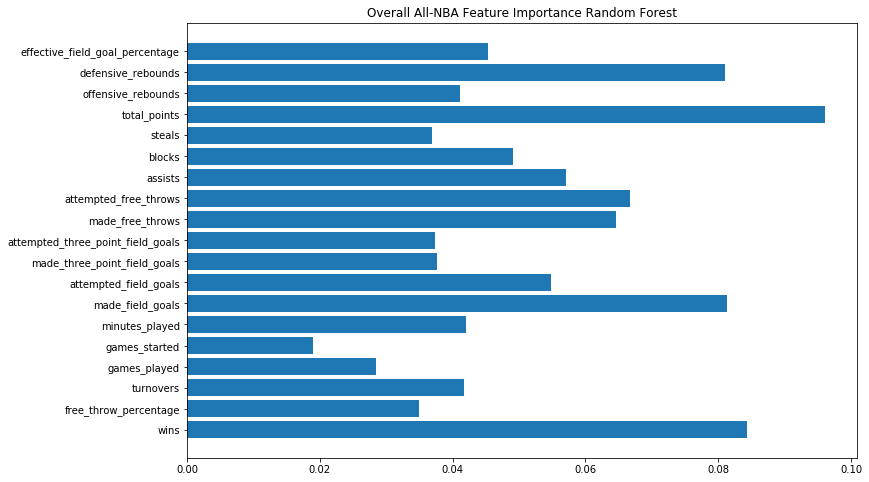

In [55]:
#feature importance
import matplotlib.pyplot as plt

importance = dict_models['Random Forest']['model'].feature_importances_
feature_names = ['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
print(feature_names)

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v), feature_names[i])


plt.figure(figsize=(12, 8))

plt.barh(feature_names, importance)
plt.title('Overall All-NBA Feature Importance Random Forest')
plt.show()



#### All-NBA Centers

{0: 0.05886705827502755, 1: -0.0045796228048575974, 2: 0.07165392121252827, 3: 0.02595023577951461, 4: 0.032296361251490595, 5: 0.06542148086451519, 6: 0.15521885007517192, 7: 0.08335737961711663, 8: -0.012882032206872701, 9: -0.012853199977217917, 10: 0.14417698805015935, 11: 0.18121679938349963, 12: 0.028658486134710615, 13: 0.17007192009345445, 14: 0.03917982000050282, 15: 0.17875728408575484, 16: 0.11583368133382696, 17: 0.2682843846885276, 18: 0.03340393061152613}
[ 0.05886706 -0.00457962  0.07165392  0.02595024  0.03229636  0.06542148
  0.15521885  0.08335738 -0.01288203 -0.0128532   0.14417699  0.1812168
  0.02865849  0.17007192  0.03917982  0.17875728  0.11583368  0.26828438
  0.03340393]


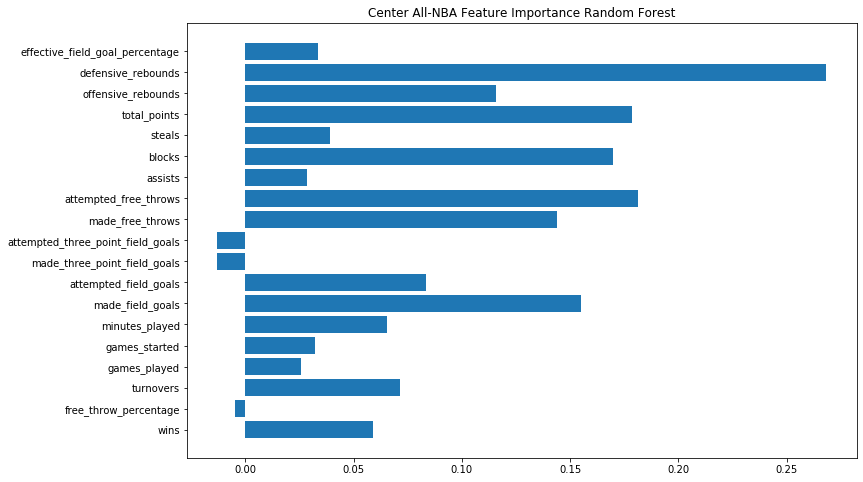

In [72]:
from sklearn.preprocessing import scale

def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)
    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

result = class_feature_importance(X_train, Y_train, importance)

importance_c = np.zeros(len(feature_names))
res1 = result.get(1)
i = 0
while(i < len(feature_names)):
    for v in res1.values():
        importance_c[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_c)
plt.title('Center All-NBA Feature Importance Random Forest')
plt.show()


#### All-NBA Forwards

In [3]:
importance_f = np.zeros(len(feature_names))
res2 = result.get(2)
i = 0
while(i < len(feature_names)):
    for v in res2.values():
        importance_f[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_f)
plt.title('Forward All-NBA Feature Importance Random Forest')
plt.show()

NameError: name 'np' is not defined

#### All-NBA Guards

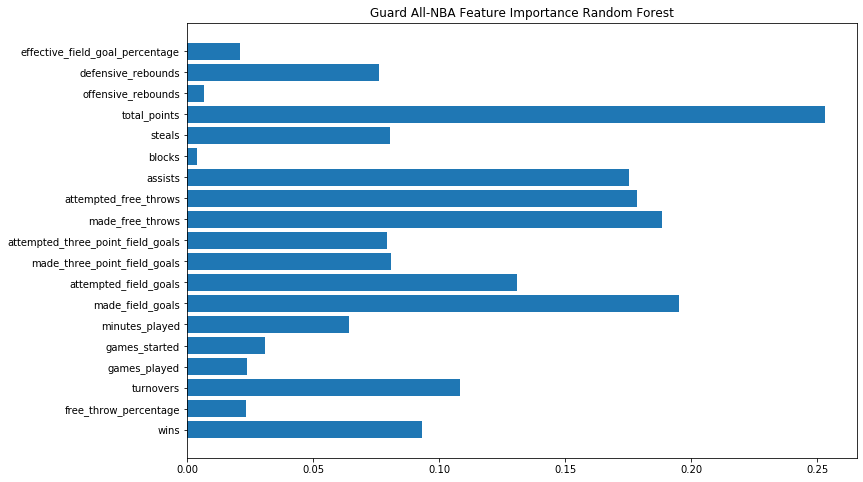

In [75]:
importance_g = np.zeros(len(feature_names))
res3 = result.get(3)
i = 0
while(i < len(feature_names)):
    for v in res3.values():
        importance_g[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_g)
plt.title('Guard All-NBA Feature Importance Random Forest')
plt.show()

#### Notes on Feature Importance
As you can see, each position weighs certain statistics differently. For guards, assists matter a lot; for centers, defensive rebounds; and for forwards a well rounded mixture of both.

### References:

https://pypi.org/project/basketball-reference-web-scraper/

https://www.basketball-reference.com/

https://scikit-learn.org/stable/

http://ataspinar.com/2017/05/26/classification-with-scikit-learn/